라이브러리 임포트


In [16]:
! pip install pandas


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
! pip install nltk


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import numpy as np
import re
import urllib.request
import matplotlib.pyplot as plt
import os
from nltk.translate.bleu_score import sentence_bleu

### Step 1: 데이터 수집


In [19]:
# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatbotData.csv")

# 데이터 로드
train_data = pd.read_csv('ChatbotData.csv')
print('데이터셋 크기 :', len(train_data))
train_data.head()

데이터셋 크기 : 11823


,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


### Step 2: 데이터 전처리


In [20]:
def preprocess_sentence(sentence):
    sentence = sentence.strip()
    # 특수문자 제거
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣ\s]", "", sentence)
    # 여러 공백을 하나의 공백으로 변환
    sentence = re.sub(r"\s+", " ", sentence)
    return sentence

# 질문과 답변 데이터 전처리
questions = [preprocess_sentence(sentence) for sentence in train_data['Q']]
answers = [preprocess_sentence(sentence) for sentence in train_data['A']]

 데이터 인코딩 (전체 과정)  
    ├── 토크나이징 (텍스트를 토큰으로 변환)  
    │   ├── SubwordTextEncoder (서브워드 단위로 분해)  
    │   │   ├── 자주 나오는 패턴을 하나의 토큰으로  
    │   │   └── 나머지는 더 작은 단위로 분해  
    │   └── 토큰을 숫자로 매핑  
    ├── 특수 토큰 추가 (START_TOKEN, END_TOKEN)  
    └── 패딩 (시퀀스 길이 통일)

### Step 3: 데이터 인코딩


##### SubwordTextEncoder 설정(토큰화)

In [21]:
# 텍스트 인코더 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

# 시작 토큰과 종료 토큰 정의
START_TOKEN = [tokenizer.vocab_size]
END_TOKEN = [tokenizer.vocab_size + 1]

# 실제 vocab_size (시작 토큰과 종료 토큰을 고려)
VOCAB_SIZE = tokenizer.vocab_size + 2

MAX_LENGTH = 40

In [22]:
def tokenize_and_filter(inputs, outputs, max_length=40):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 각 문장을 토큰화
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN
        
        if len(sentence1) <= max_length and len(sentence2) <= max_length:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=max_length, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=max_length, padding='post')
    
    return tokenized_inputs, tokenized_outputs

# 데이터 인코딩
questions_encoded, answers_encoded = tokenize_and_filter(questions, answers)

# 데이터셋 생성
BATCH_SIZE = 64
BUFFER_SIZE = 20000

dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions_encoded,
        'dec_inputs': answers_encoded[:, :-1]
    },
    {
        'outputs': answers_encoded[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

##### 마스킹

In [64]:
def create_padding_mask(seq):
    # seq shape: (batch_size, seq_length)
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_length)

def create_look_ahead_mask(size):
    # size는 스칼라 값이어야 함
    # size should be a scalar value
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def create_masks(inp, tar):
    # 인코더 패딩 마스크
    # Encoder padding mask
    enc_padding_mask = create_padding_mask(inp)
    
    # 디코더의 두 번째 어텐션 블록용 패딩 마스크
    # Padding mask for decoder's second attention block
    dec_padding_mask = create_padding_mask(inp)
    
    # 디코더의 첫 번째 어텐션 블록용 룩-어헤드 마스크
    # Look-ahead mask for decoder's first attention block
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    
    return enc_padding_mask, combined_mask, dec_padding_mask

### Step 4: 모델 구성

##### 포지셔널 인코딩 레이어

In [65]:
class PositionalEncoding(tf.keras.layers.Layer):
   
  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  
  # 위치별 각도 계산       
  @staticmethod
  def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(np.arange(position)[:, np.newaxis],
                        np.arange(d_model)[np.newaxis, :],
                        d_model)
    # sin 함수는 짝수 인덱스에 적용
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # cos 함수는 홀수 인덱스에 적용
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

##### 스케일드 닷 프로덕트 어텐션

In [66]:
def scaled_dot_product_attention(query, key, value, mask):
    # query 크기 : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    # key 크기 : (batch_size, num_heads, key의 문장 길이, d_model/num_heads)
    # value 크기 : (batch_size, num_heads, value의 문장 길이, d_model/num_heads)
    # padding_mask : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)

    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # scale matmul_qk
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # add the mask to zero out padding tokens
    if mask is not None:
        logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k)
    attention_weights = tf.nn.softmax(logits, axis=-1)

    output = tf.matmul(attention_weights, value)

    return output, attention_weights

##### 멀티 헤드 어텐션

In [67]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs['value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # linear layers
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # split heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # scaled dot-product attention
        scaled_attention, _ = scaled_dot_product_attention(query, key, value, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # concatenation of heads
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        # final linear layer
        outputs = self.dense(concat_attention)

        return outputs

##### 인코더와 디코더 레이어 구현

In [68]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        attn_output = self.mha({'query': x, 'key': x, 'value': x, 'mask': mask})
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = tf.keras.Sequential([
            tf.keras.layers.Dense(dff, activation='relu'),
            tf.keras.layers.Dense(d_model)
        ])

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1 = self.mha1({'query': x, 'key': x, 'value': x, 'mask': look_ahead_mask})
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2 = self.mha2({
            'query': out1,
            'key': enc_output,
            'value': enc_output,
            'mask': padding_mask
        })
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        return self.layernorm3(ffn_output + out2)

누락된 Encoder, Decoder 클래스 추가

In [69]:
class Encoder(tf.keras.layers.Layer):
    # __init__ 메서드는 동일
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, rate=0.1):
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(input_vocab_size, d_model)

        self.enc_layers = [
            EncoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    # 변경된 call 메서드
    def call(self, inputs, training=None, mask=None):  # <- 변경: 매개변수 이름을 inputs로 변경하고 기본값 추가
        x = self.embedding(inputs)
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)  # <- 변경: training을 키워드 인수로 전달

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)  # <- 변경: 모든 인수를 키워드로 전달

        return x

class Decoder(tf.keras.layers.Layer):
    # __init__ 메서드는 동일
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, rate=0.1):
        super(Decoder, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(target_vocab_size, d_model)

        self.dec_layers = [
            DecoderLayer(d_model, num_heads, dff, rate)
            for _ in range(num_layers)
        ]
        self.dropout = tf.keras.layers.Dropout(rate)

    # 변경된 call 메서드
    def call(self, inputs, enc_output, training=None, look_ahead_mask=None, padding_mask=None):  # <- 변경: 매개변수 이름과 기본값 추가
        x = self.embedding(inputs)
        x = self.pos_encoding(x)
        x = self.dropout(x, training=training)  # <- 변경: training을 키워드 인수로 전달

        for i in range(self.num_layers):
            x = self.dec_layers[i](
                x, 
                enc_output=enc_output,  # <- 변경: 모든 인수를 키워드로 전달
                training=training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )

        return x


##### 전체 트랜스포머 모델 구현

In [74]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, rate=0.1):
        super(Transformer, self).__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                             input_vocab_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                             target_vocab_size, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training=None):
        if isinstance(inputs, dict):
            inp = inputs['inputs']
            tar = inputs['dec_inputs']
        else:
            inp, tar = inputs
            
        # 입력값들을 int32로 캐스팅
        inp = tf.cast(inp, tf.int32)
        tar = tf.cast(tar, tf.int32)
        
        # 마스크 생성
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar)
        
        # 인코더 실행 (키워드 인자로 변경)
        enc_output = self.encoder(
            inputs=inp,
            training=training,
            mask=enc_padding_mask
        )
        
        # 디코더 실행 (키워드 인자로 변경)
        dec_output = self.decoder(
            inputs=tar,
            enc_output=enc_output,
            training=training,
            look_ahead_mask=combined_mask,
            padding_mask=dec_padding_mask
        )
        
        final_output = self.final_layer(dec_output)
        return final_output
    
# 하이퍼파라미터 설정
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1

# 모델 생성
transformer = Transformer(
    num_layers=NUM_LAYERS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dff=DFF,
    input_vocab_size=VOCAB_SIZE,
    target_vocab_size=VOCAB_SIZE,
    rate=DROPOUT)

##### 학습 설정 및 손실 함수 정의

In [78]:
# 하이퍼파라미터 설정
NUM_LAYERS = 2
D_MODEL = 256
NUM_HEADS = 8
DFF = 512
DROPOUT = 0.1
EPOCHS = 20
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# Learning Rate Schedule 설정
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    def get_config(self):
        # 설정을 저장하고 복원하는데 필요한 정보를 반환
        # Return information needed to save and restore the configuration
        return {
            'd_model': self.d_model,
            'warmup_steps': self.warmup_steps
        }
        
# 옵티마이저 설정
learning_rate = CustomSchedule(D_MODEL)
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

# 손실 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

# 메트릭 설정
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

# 모델 컴파일
transformer.compile(
    optimizer=optimizer,
    loss=loss_function,
    metrics=['accuracy']
)

# 체크포인트 설정
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer
)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# 체크포인트가 있다면 최신 체크포인트를 복원
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('최신 체크포인트가 복원되었습니다!')

# 콜백 함수 설정
callbacks = [
    # 조기 종료
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=3,
        restore_best_weights=True
    ),
    # 체크포인트 저장
    tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_path + "/weights.{epoch:02d}-{loss:.4f}.keras",
        save_best_only=True,
        monitor='loss'
    ),
    # 텐서보드
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    # Learning Rate 조절
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='loss',
        factor=0.2,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

##### 학습 루프 구현

In [79]:
# @tf.function
# def train_step(inp, tar):
#     tar_inp = tar[:, :-1]
#     tar_real = tar[:, 1:]

#     with tf.GradientTape() as tape:
#         predictions = transformer([inp, tar_inp], training=True)
#         loss = loss_function(tar_real, predictions)

#     gradients = tape.gradient(loss, transformer.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

#     train_loss(loss)
#     train_accuracy(tar_real, predictions)

# EPOCHS = 20

# for epoch in range(EPOCHS):
#     train_loss.reset_state()
#     train_accuracy.reset_state()

#     for (batch, (inp, tar)) in enumerate(dataset):
#         train_step(inp['inputs'], tar['outputs'])

#         if batch % 50 == 0:
#             print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

#     print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

In [80]:
# 모델 학습
history = transformer.fit(
    dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Epoch 1/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 116s 571ms/step - accuracy: 0.0256 - loss: 7.7441 - learning_rate: 4.5705e-05
Epoch 2/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 101s 546ms/step - accuracy: 0.0256 - loss: 7.1530 - learning_rate: 9.1410e-05
Epoch 3/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 99s 536ms/step - accuracy: 0.0257 - loss: 6.7728 - learning_rate: 1.3711e-04
Epoch 4/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 100s 541ms/step - accuracy: 0.0262 - loss: 6.5863 - learning_rate: 1.8282e-04
Epoch 5/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 99s 535ms/step - accuracy: 0.0269 - loss: 6.2467 - learning_rate: 2.2852e-04
Epoch 6/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 102s 550ms/step - accuracy: 0.0282 - loss: 6.0247 - learning_rate: 2.7423e-04
Epoch 7/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 102s 550ms/step - accuracy: 0.0289 - loss: 5.9081 - learning_rate: 3.1993e-04
Epoch 8/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 101s 544ms/step - accuracy: 0.0296 - loss: 5.7628 - learning_rate: 3.6564e-04
Epoch 9/20
185/185 ━━━━━━━━━━━━━━━━━━━━ 101s 546ms/step - 

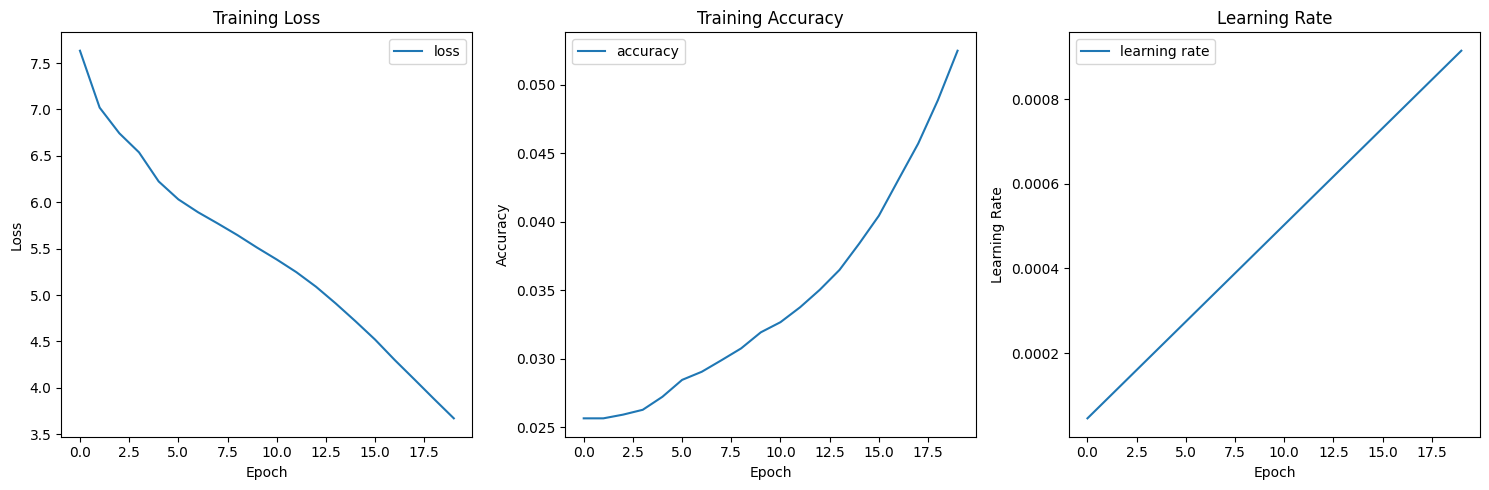

In [82]:
# 학습 결과 시각화
# Visualize training results
plt.figure(figsize=(15, 5))

# 손실 그래프
# Loss graph
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='loss')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
# Accuracy graph
plt.subplot(1, 3, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 학습률 그래프
# Learning rate graph
plt.subplot(1, 3, 3)
plt.plot(history.history['learning_rate'], label='learning rate')  # 'lr'을 'learning_rate'로 변경
plt.title('Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()

plt.tight_layout()
plt.show()

### Step 5: 모델 평가


##### 문장 예측 함수

In [83]:
# 문장 예측을 위한 함수
def inference(sentence):
    # 입력 문장 전처리
    sentence = preprocess_sentence(sentence)
    
    # 입력 문장을 토큰화하고 패딩
    encoder_input = tf.expand_dims(START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더 입력은 '[START]'로 시작
    decoder_input = tf.expand_dims(START_TOKEN, 0)
    
    # 출력 문장 생성
    for i in range(MAX_LENGTH):
        predictions = transformer(
            inputs=[encoder_input, decoder_input],
            training=False
        )
        
        # 마지막 단어의 예측값 얻기
        predictions = predictions[:, -1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # '[END]' 토큰이 나오면 예측 종료
        if predicted_id == END_TOKEN[0]:
            break
            
        # 예측된 단어를 디코더 입력에 연결
        decoder_input = tf.concat([decoder_input, predicted_id], axis=-1)
    
    # 예측된 토큰을 문장으로 변환
    predicted_sentence = tokenizer.decode([i for i in decoder_input[0] if i < tokenizer.vocab_size])
    
    return predicted_sentence

##### 실제 대화 함수

In [84]:
# 실제 대화를 위한 함수
def chat():
    print("챗봇과 대화를 시작합니다 (종료하려면 'quit' 또는 '종료'를 입력하세요)")
    
    while True:
        user_input = input("사용자: ")
        
        if user_input.lower() in ['quit', '종료']:
            print("대화를 종료합니다.")
            break
            
        try:
            # 응답 생성
            response = inference(user_input)
            print("챗봇:", response)
            
        except Exception as e:
            print("오류가 발생했습니다:", str(e))
            continue

# 테스트 문장들로 모델 평가
def test_model():
    print("\n=== 모델 테스트 ===")
    
    test_sentences = [
        "안녕하세요",
        "오늘 날씨가 어때요?",
        "점심 뭐 먹을까요?",
        "취미가 뭐예요?",
        "주말에 뭐해요?"
    ]
    
    for test_sentence in test_sentences:
        try:
            response = inference(test_sentence)
            print("입력:", test_sentence)
            print("응답:", response)
            print()
        except Exception as e:
            print(f"테스트 문장 '{test_sentence}' 처리 중 오류 발생:", str(e))
            print()


##### 모델 성능 메트릭 평가

In [85]:
# 모델 성능 메트릭 평가
def evaluate_metrics(test_dataset):
    print("\n=== 모델 성능 평가 ===")
    
    total_bleu = 0
    total_samples = 0
    
    for batch in test_dataset:
        input_sentence = batch[0]
        target_sentence = batch[1]
        
        predicted_sentence = inference(input_sentence)
        
        # BLEU 스코어 계산
        bleu_score = sentence_bleu([target_sentence.split()], 
                                 predicted_sentence.split(),
                                 weights=(0.25, 0.25, 0.25, 0.25))
        
        total_bleu += bleu_score
        total_samples += 1
    
    average_bleu = total_bleu / total_samples
    print(f"평균 BLEU 점수: {average_bleu:.4f}")


##### 대화 예시 테스트

In [86]:
# 대화 예시 테스트
print("\n=== 대화 예시 테스트 ===")
test_conversations = [
    "안녕하세요",
    "오늘 기분이 어때요?",
    "취미가 뭐예요?",
    "주말에 뭐하시나요?",
    "좋아하는 음식은 뭐예요?"
]

print("=== 대화 테스트 시작 ===")
for question in test_conversations:
    response = inference(question)
    print("사용자:", question)
    print("챗봇:", response)
    print()

# 대화 시작
print("\n실제 대화를 시작하시겠습니까? (y/n)")
if input().lower() == 'y':
    chat()


=== 대화 예시 테스트 ===
=== 대화 테스트 시작 ===
사용자: 안녕하세요
챗봇: 맛나게 드세요

사용자: 오늘 기분이 어때요?
챗봇: 제가 들어드릴게요

사용자: 취미가 뭐예요?
챗봇: 나중에 도움이 될 거예요

사용자: 주말에 뭐하시나요?
챗봇: 맛있게 드세요

사용자: 좋아하는 음식은 뭐예요?
챗봇: 그 사람도 그럴 수도 있어요


실제 대화를 시작하시겠습니까? (y/n)
챗봇과 대화를 시작합니다 (종료하려면 'quit' 또는 '종료'를 입력하세요)
챗봇: 잘 견디고 있어요
챗봇: 저도 해보고 싶네요
챗봇: 맛나게 드세요
챗봇: 좋은 친구를 두셨네요
챗봇: 먼저 다가가나봐요
대화를 종료합니다.


In [87]:
# 모델 테스트
test_model()

# 성능 평가 (테스트 데이터셋이 있는 경우)
# evaluate_metrics(test_dataset)




=== 모델 테스트 ===
입력: 안녕하세요
응답: 맛나게 드세요

입력: 오늘 날씨가 어때요?
응답: 즐거운 시작 응원해요

입력: 점심 뭐 먹을까요?
응답: 잘할 수 있을 거예요

입력: 취미가 뭐예요?
응답: 나중에 도움이 될 거예요

입력: 주말에 뭐해요?
응답: 좋은 친구를 두셨네요



In [88]:
# 실제 대화 시작
chat()

챗봇과 대화를 시작합니다 (종료하려면 'quit' 또는 '종료'를 입력하세요)
챗봇: 맛나게 드세요
챗봇: 좋은 만남이었길 바라요
챗봇: 잘 하실 거예요
챗봇: 먼저 다가가나봐요
대화를 종료합니다.
